# Deep Neural Network for Breast Cancer Classification

This project demonstrates how to build and train a deep neaural network for classification using the PyTorch library. The dataset used is the Breast Cancer Wisconsin (Diagonostic) Data Set.

#### Setup environment

In [452]:
%pip install torch==2.3.1
%pip install ucimlrepo==0.0.7

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


##### Load the Data

The Breast Cancer Wisconsin (Diagnostic) dataset is a classic dataset used for classification tasks. It contains 569 samples of breast cancer cells, each with 30 features. The dataset is divided into two classes: begin and malignant. The goal is to classify the breast cancer cells into one of the two classes.

The dataset is free to use and is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license. 

In [453]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
x = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# print the frist few rows of the data
display(x.head())

# print the first few rows of the target
display(y.head())


,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


,Diagnosis
0,M
1,M
2,M
3,M
4,M


Then let us check the shape of the datatset.

In [454]:
print(f'x shape: {x.shape}')
print(f'y shape: {y.shape}')

x shape: (569, 30)
y shape: (569, 1)


As shown, the dataset has 569 samples and 30 features. The target variable is the diagnosis column, which contains the class lables for each sample. The class labels are either 'M' (malignant) or 'B' (benign).

We will then check the distribution of the target variable.

In [455]:
print(y['Diagnosis'].value_counts())

Diagnosis
B    357
M    212
Name: count, dtype: int64


Note that the dataset is imbalanced (uneven), with more benign samples than malignant samples.

We will now process the data. Randomly choose 212 samples in 'M' and 212 samples in 'B'.

In [456]:
import pandas as pd

# Combine features and target into a single DataFrame for easier manipulation
data = pd.concat([x, y], axis=1)

# display(data)

# Seperate the two classes
data_B = data[data["Diagnosis"] == "B"]
data_M = data[data["Diagnosis"] == "M"]

# Select 212 samples from each class
data_B = data_B.sample(n=212, random_state=42)
data_m = data_M.sample(n=212, random_state=42)

# Combine the two classes
balanced_data = pd.concat([data_B, data_M])

display(balanced_data["Diagnosis"].value_counts())

Diagnosis
B    212
M    212
Name: count, dtype: int64

There are 212 samples in each class, with a toal of 414 samples. This means that the dataset is balanced. 

We will be using 80% of the samples for training and the remaining 20% for testing.

#### Step 2: Data Preprocessing

Before feeding the data into our neural network, we need to preprocess it. This involves seperating the features and labels, splitting the data into training and test sets, and standarizing the feature values.

In [504]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Seperate features and targets
x = balanced_data.drop('Diagnosis', axis=1)
y = balanced_data['Diagnosis']

# Convert the targets to binary labels
y = y.map({'B': 0, 'M': 1})

display(x)
display(y)

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
395,14.060,17.18,89.75,609.1,0.08045,0.05361,0.026810,0.03251,0.1641,0.05764,...,14.92,25.34,96.42,684.5,0.10660,0.12310,0.08460,0.07911,0.2523,0.06609
110,9.777,16.99,62.50,290.2,0.10370,0.08404,0.043340,0.01778,0.1584,0.07065,...,11.05,21.47,71.68,367.0,0.14670,0.17650,0.13000,0.05334,0.2533,0.08468
481,13.900,19.24,88.73,602.9,0.07991,0.05326,0.029950,0.02070,0.1579,0.05594,...,16.41,26.42,104.40,830.5,0.10640,0.14150,0.16730,0.08150,0.2356,0.07603
493,12.460,12.83,78.83,477.3,0.07372,0.04043,0.007173,0.01149,0.1613,0.06013,...,13.19,16.36,83.24,534.0,0.09439,0.06477,0.01674,0.02680,0.2280,0.07028
136,11.710,16.67,74.72,423.6,0.10510,0.06095,0.035920,0.02600,0.1339,0.05945,...,13.33,25.48,86.16,546.7,0.12710,0.10280,0.10460,0.06968,0.1712,0.07343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,20.920,25.09,143.00,1347.0,0.10990,0.22360,0.317400,0.14740,0.2149,0.06879,...,24.29,29.41,179.10,1819.0,0.14070,0.41860,0.65990,0.25420,0.2929,0.09873
564,21.560,22.39,142.00,1479.0,0.11100,0.11590,0.243900,0.13890,0.1726,0.05623,...,25.45,26.40,166.10,2027.0,0.14100,0.21130,0.41070,0.22160,0.2060,0.07115
565,20.130,28.25,131.20,1261.0,0.09780,0.10340,0.144000,0.09791,0.1752,0.05533,...,23.69,38.25,155.00,1731.0,0.11660,0.19220,0.32150,0.16280,0.2572,0.06637
566,16.600,28.08,108.30,858.1,0.08455,0.10230,0.092510,0.05302,0.1590,0.05648,...,18.98,34.12,126.70,1124.0,0.11390,0.30940,0.34030,0.14180,0.2218,0.07820


395    0
110    0
481    0
493    0
136    0
      ..
563    1
564    1
565    1
566    1
567    1
Name: Diagnosis, Length: 424, dtype: int64

Looking good.

The data will be split into 80% trainig and 20% test sets.

In [505]:
# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
# stratify ensures the same ratio of classes in both training and test sets.

print(f"x_train shape:  {x_train.shape}")
print(f"y_train shape:  {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape:  {y_test.shape}")

x_train shape:  (339, 30)
y_train shape:  (339,)
x_test shape: (85, 30)
y_test shape:  (85,)


Then we standarize the feature values using the `StandardScaler` from scikit-learn and convert the NumPy arrays to PyTorch tensors.

In [506]:
scaler = StandardScaler()


# Fit the scaler on the training data and transform it
x_trainn = scaler.fit_transform(x_train)
# Transform the test data using the same scaler
x_testt = scaler.transform(x_test)

In [500]:
from torch.utils.data import DataLoader, TensorDataset

# Standarize the data
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
x_train = scaler.fit_transform(x_train)
# Transform the test data using the same scaler
x_test = scaler.transform(x_test)

# Convert to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and test sets
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


#### Step 3: Build and Train the Neural Network Model

In [491]:
import torch.nn as nn

# nn.Linear: "Linear" = Dense Layer in Keras
class ClassificationNet(nn.Module):
    def __init__(self, input_units=30, hidden_units=64, output_units=2): #dropout_rate=0.1
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(input_units, hidden_units)
        # self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_units, output_units)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return x
    
# Instantiate the model
model = ClassificationNet(input_units = 30, hidden_units = 64, output_units= 2)


In [492]:
print(model)

ClassificationNet(
  (fc1): Linear(in_features=30, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)


Then we define the loss function and optimizer. We can use the CrossEntropyLoss loss function, which is commonly used for multi-class classification problems. And the Adam optimizer will be used to update the weights of the neural network during training.

In [493]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#### Step 4: Train the Model

In [494]:
epochs = 12
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            test_outputs = model(x_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch [{epoch + 1} / {epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch [1 / 12], Train Loss: 0.2828, Test Loss: 0.1603
Epoch [2 / 12], Train Loss: 0.1131, Test Loss: 0.1193
Epoch [3 / 12], Train Loss: 0.0900, Test Loss: 0.1036
Epoch [4 / 12], Train Loss: 0.0783, Test Loss: 0.0967
Epoch [5 / 12], Train Loss: 0.0715, Test Loss: 0.0865
Epoch [6 / 12], Train Loss: 0.0665, Test Loss: 0.0984
Epoch [7 / 12], Train Loss: 0.0605, Test Loss: 0.0829
Epoch [8 / 12], Train Loss: 0.0555, Test Loss: 0.0867
Epoch [9 / 12], Train Loss: 0.0499, Test Loss: 0.0809
Epoch [10 / 12], Train Loss: 0.0466, Test Loss: 0.0808
Epoch [11 / 12], Train Loss: 0.0442, Test Loss: 0.0716
Epoch [12 / 12], Train Loss: 0.0409, Test Loss: 0.0806


#### Step 5: Visualize the Training and Test Loss

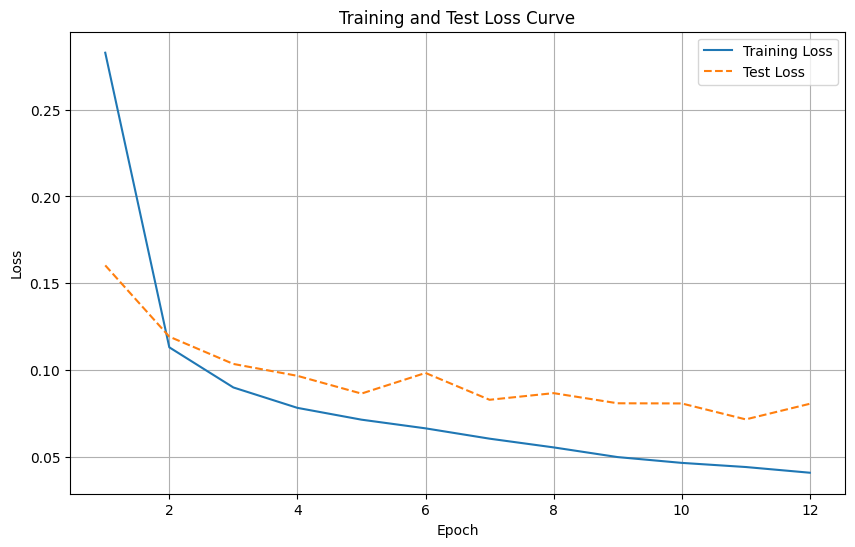

In [496]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle = "--")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

#### Extra: Rebuild The Same Model With Keras 

In [508]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf


# Encoder - Compresses the input data into a smaller representation
input_layer = Input(shape=(30))
x = Dense(64, activation='relu')(input_layer)
output_layer = Dense(2, activation='softmax')(x)

# Autoencoder model 
model = Model(input_layer, output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

# Summary of the model
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
dense_137 (Dense)            (None, 64)                1984      
_________________________________________________________________
dense_138 (Dense)            (None, 2)                 130       
Total params: 2,114
Trainable params: 2,114
Non-trainable params: 0
_________________________________________________________________


In [509]:
model.fit(
    x_trainn, 
    y_train, 
    epochs=12,
    batch_size=2, 
    shuffle=True,
    validation_data=(x_testt, y_test)
)


Epoch 1/12
170/170 [==============================] - 1s 3ms/step - loss: 0.2587 - val_loss: 0.1566
Epoch 2/12
170/170 [==============================] - 0s 2ms/step - loss: 0.1197 - val_loss: 0.1060
Epoch 3/12
170/170 [==============================] - 0s 2ms/step - loss: 0.0956 - val_loss: 0.0962
Epoch 4/12
170/170 [==============================] - 0s 2ms/step - loss: 0.0811 - val_loss: 0.0934
Epoch 5/12
170/170 [==============================] - 0s 2ms/step - loss: 0.0737 - val_loss: 0.0805
Epoch 6/12
170/170 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0752
Epoch 7/12
170/170 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0797
Epoch 8/12
170/170 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0748
Epoch 9/12
170/170 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0755
Epoch 10/12
170/170 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0660

Comparing these values, Keras slightly outperformed the PyTorch model.